In [1]:
from sklearn.linear_model import SGDClassifier
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# Visualization Library
import matplotlib.pyplot as plt 
import seaborn as sns
from collections import Counter
import tensorflow as tf
from sklearn.model_selection import train_test_split,StratifiedKFold,GridSearchCV
import pdb
import tensorflow.contrib.keras as keras
from tensorflow.contrib.keras import losses,optimizers,metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix,classification_report
from tensorboard.plugins.hparams import api as hp
import os.path

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [2]:
X_train=pd.read_csv("processed_data/X_train.csv")
X_test=pd.read_csv("processed_data/X_test.csv")
y_train=pd.read_csv("processed_data/y_train.csv")
y_test=pd.read_csv("processed_data/y_test.csv")

try:
    os.stat('saved_models')
except:
    os.mkdir('saved_models')  
    

In [3]:
#Temporary for quick testing
#tempcount = 10
#X_train = X_train[:tempcount]
#X_test = X_test[:tempcount]
#y_train = y_train[:tempcount]
#y_test = y_test[:tempcount]
#End of temporary


scaler = MinMaxScaler()
X_train = X_train.drop(['Unnamed: 0'], axis=1)
X_train = scaler.fit_transform(X_train)
y_train = pd.get_dummies(y_train).astype(float)
y_train = y_train.drop(['Unnamed: 0'], axis=1)

X_test = X_test.drop(['Unnamed: 0'], axis=1)
X_test = scaler.fit_transform(X_test)
y_test = pd.get_dummies(y_test).astype(float)
y_test = y_test.drop(['Unnamed: 0'], axis=1)

print("X_train",len(X_train))
print("X_test",len(X_test))
print("y_train",len(y_train))
print("y_test",len(y_test))

X_train 103864
X_test 25976
y_train 103864
y_test 25976


In [4]:
np.random.seed(101)
tf.set_random_seed(101)

In [5]:
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam', 'sgd']))
HP_NUM_UNITS1 = hp.HParam('num_units 1', hp.Discrete([50,100, 150])) 
HP_NUM_UNITS2 = hp.HParam('num_units 2', hp.Discrete([50,100, 150]))
METRIC_ACCURACY = 'accuracy'


In [6]:
def train_test_model(run_dir, hparams, identifier):
  model = tf.keras.Sequential([
    keras.layers.Dense(len(X_train), input_dim=27, activation='relu'),
    keras.layers.Dense(hparams[HP_NUM_UNITS1], activation='relu'),
    keras.layers.Dense(hparams[HP_NUM_UNITS2], activation='relu'),
    keras.layers.Dense(2, activation='softmax')
  ])

  model.compile(optimizer=hparams[HP_OPTIMIZER],
                loss='binary_crossentropy',
                metrics=['accuracy'])
    
  tensorboard_callback = keras.callbacks.TensorBoard(log_dir=run_dir)

  training_history = model.fit(X_train,y_train, epochs=50, callbacks=[tensorboard_callback])
    
  model.save('saved_models/'+identifier+'.h5')

  metrics = model.evaluate(X_test, y_test)
  return metrics

In [7]:
def run(run_dir, hparams, identifier):
  with tf.summary.FileWriter(run_dir) as writer:
    hp.hparams(hparams)  # record the values used in this trial
    metrics = train_test_model(run_dir, hparams, identifier)

    
    tf.summary.scalar(METRIC_ACCURACY, metrics)
    writer.flush()
    return metrics

In [8]:

hparam_df = pd.DataFrame(columns = ['identifier','num_units1', 'num_units2', 'optimizer', 'loss', 'accuracy'])

if os.path.isfile("hparam.csv"):
    hparam_df=pd.read_csv("hparam.csv")
else:
    hparam_df.to_csv("hparam.csv")

for num_units1 in HP_NUM_UNITS1.domain.values:
  for num_units2 in HP_NUM_UNITS2.domain.values:
    for optimizer in HP_OPTIMIZER.domain.values:
        
        identifier = str(num_units1)+"_"+str(num_units2)+"_"+optimizer;
        
        if os.path.isfile('saved_models/'+identifier+'.h5') and hparam_df['identifier'].str.contains(identifier).any() and os.path.isdir('logs/hparam_tuning/'+identifier+'/train/'):
            continue
          
        hparams = {
        HP_NUM_UNITS1: num_units1,
        HP_NUM_UNITS2: num_units2,
        HP_OPTIMIZER: optimizer
        }
        
        print('--- Starting trial: %s' % identifier)
        print({h.name: hparams[h] for h in hparams})
        metrics = run('logs/hparam_tuning/' + identifier, hparams, identifier)
        
        hp_append = {'identifier' : identifier,'num_units1': num_units1, 'num_units2': num_units2, 'optimizer': optimizer, 'loss':metrics[0], 'accuracy':metrics[1]}
        hparam_df = hparam_df.append(hp_append, ignore_index = True)
        hparam_df.to_csv("hparam.csv")
        


In [38]:

combined_X = np.concatenate((X_train, X_test))
combined_y = np.concatenate((y_train, y_test))


In [41]:
final_mlp_model = tf.keras.models.load_model('saved_models/50_50_adam.h5')
history = final_mlp_model.fit(combined_X,combined_y, epochs=50, validation_split=0.200061,)

Train on 103864 samples, validate on 25976 samples
Epoch 1/50
103864/103864 [==============================] - 26s 252us/sample - loss: 0.0767 - acc: 0.9658 - val_loss: 0.1038 - val_acc: 0.9596
Epoch 2/50
103864/103864 [==============================] - 26s 250us/sample - loss: 0.0770 - acc: 0.9660 - val_loss: 0.1846 - val_acc: 0.9427
Epoch 3/50
103864/103864 [==============================] - 25s 245us/sample - loss: 0.0770 - acc: 0.9659 - val_loss: 0.1074 - val_acc: 0.9589
Epoch 4/50
103864/103864 [==============================] - 25s 242us/sample - loss: 0.0767 - acc: 0.9660 - val_loss: 0.1083 - val_acc: 0.9593
Epoch 5/50
103864/103864 [==============================] - 25s 241us/sample - loss: 0.0767 - acc: 0.9658 - val_loss: 0.1462 - val_acc: 0.9536
Epoch 6/50
103864/103864 [==============================] - 26s 246us/sample - loss: 0.0760 - acc: 0.9664 - val_loss: 0.1328 - val_acc: 0.9557
Epoch 7/50
103864/103864 [==============================] - 25s 245us/sample - loss: 0.0758

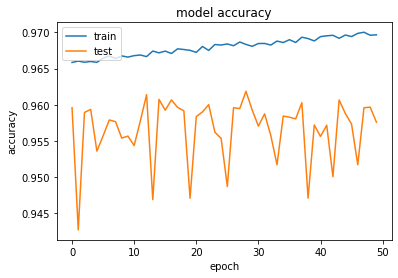

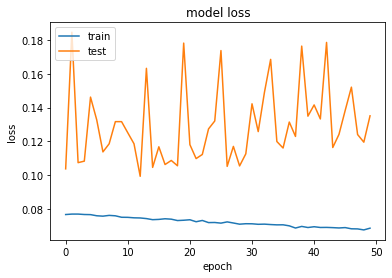

In [44]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()